# IPL First Innings Score Prediction Model

## Background

Here, a regression model is created to predict first innings score in an Indian Premier League (IPL) game. Assumptions of the model are:
- First Innings score only
- Only current teams considered
- Only Indian venues considered
- Score prediction after the batting team has played at least 5 overs, i.e., score after 5 overs required
- The model also requires the runs scored and wickets in the last 5 overs

The model returns a predicted total score for the team batting first.

## Dataset

The dataset was acquired from kaggle: https://www.kaggle.com/datasets/patrickb1912/ipl-complete-dataset-20082020

The dataset spans from 2008 to 2020 and consists of two tables. First is a ball by ball data of every match where each row is a single ball bowled in that match. Second is a overall match data where each row corresponds to a single match. The two tables were joined using the 'id' column in MS SQL Server. Furthermore, two additional were created: last5_runs (runs in last 5 overs) and last5_wickets (wickets in last 5 overs). Finally, the required data was exported as csv.

## Importing necessary libraries and the dataset

In [67]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle


In [68]:
df = pd.read_csv('./data/data.csv')
df.head()


,id,date,venue,inning,batting_team,bowling_team,over,runs,wickets,last5_runs,last5_wickets,total
0,335982,2008-04-18,M Chinnaswamy Stadium,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,1,0,1,0,222
1,335982,2008-04-18,M Chinnaswamy Stadium,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,1,0,1,0,222
2,335982,2008-04-18,M Chinnaswamy Stadium,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,2,0,2,0,222
3,335982,2008-04-18,M Chinnaswamy Stadium,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,2,0,2,0,222
4,335982,2008-04-18,M Chinnaswamy Stadium,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,2,0,2,0,222


In [69]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193468 entries, 0 to 193467
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             193468 non-null  int64 
 1   date           193468 non-null  object
 2   venue          193468 non-null  object
 3   inning         193468 non-null  int64 
 4   batting_team   193468 non-null  object
 5   bowling_team   193277 non-null  object
 6   over           193468 non-null  int64 
 7   runs           193468 non-null  int64 
 8   wickets        193468 non-null  int64 
 9   last5_runs     193468 non-null  int64 
 10  last5_wickets  193468 non-null  int64 
 11  total          193468 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 17.7+ MB


## Data Pre-Processing

#### Correcting data type of 'date' column

In [70]:
df.date = pd.to_datetime(df.date)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193468 entries, 0 to 193467
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   id             193468 non-null  int64         
 1   date           193468 non-null  datetime64[ns]
 2   venue          193468 non-null  object        
 3   inning         193468 non-null  int64         
 4   batting_team   193468 non-null  object        
 5   bowling_team   193277 non-null  object        
 6   over           193468 non-null  int64         
 7   runs           193468 non-null  int64         
 8   wickets        193468 non-null  int64         
 9   last5_runs     193468 non-null  int64         
 10  last5_wickets  193468 non-null  int64         
 11  total          193468 non-null  int64         
dtypes: datetime64[ns](1), int64(8), object(3)
memory usage: 17.7+ MB


#### Replacing old team names

In [72]:
df.batting_team.replace('Gujarat Lions', 'Gujarat Titans', inplace=True)
df.bowling_team.replace('Gujarat Lions', 'Gujarat Titans', inplace=True)
df.batting_team.replace('Delhi Daredevils', 'Delhi Capitals', inplace=True)
df.bowling_team.replace('Delhi Daredevils', 'Delhi Capitals', inplace=True)


In [73]:
df.batting_team.unique()


array(['Kolkata Knight Riders', 'Royal Challengers Bangalore',
       'Chennai Super Kings', 'Kings XI Punjab', 'Rajasthan Royals',
       'Delhi Capitals', 'Mumbai Indians', 'Deccan Chargers',
       'Kochi Tuskers Kerala', 'Pune Warriors', 'Sunrisers Hyderabad',
       'Rising Pune Supergiants', 'Gujarat Titans',
       'Rising Pune Supergiant'], dtype=object)

In [74]:
df.bowling_team.unique()


array(['Royal Challengers Bangalore', 'Kolkata Knight Riders',
       'Kings XI Punjab', 'Chennai Super Kings', 'Delhi Capitals',
       'Rajasthan Royals', 'Mumbai Indians', 'Deccan Chargers',
       'Kochi Tuskers Kerala', 'Pune Warriors', nan,
       'Sunrisers Hyderabad', 'Rising Pune Supergiants', 'Gujarat Titans',
       'Rising Pune Supergiant'], dtype=object)

#### Filtering data to keep only active teams

In [75]:
active_teams = ['Kolkata Knight Riders', 'Royal Challengers Bangalore',
                'Chennai Super Kings', 'Kings XI Punjab', 'Rajasthan Royals',
                'Mumbai Indians', 'Sunrisers Hyderabad', 'Delhi Capitals', 'Gujarat Titans']


In [76]:
df = df[(df.batting_team.isin(active_teams)) &
        (df.bowling_team.isin(active_teams))]


#### Filtering data to keep only last 15 overs

In [77]:
df = df[df.over >= 5]


#### Filtering data to keep only first innings

In [78]:
df = df[df.inning == 1]


#### Replacing venue names

In [79]:
df.venue.replace('M Chinnaswamy Stadium',
                 'M.Chinnaswamy Stadium', inplace=True)


In [80]:
df.venue.replace('Punjab Cricket Association IS Bindra Stadium, Mohali',
                 'Punjab Cricket Association Stadium, Mohali', inplace=True)


In [81]:
df.venue.replace('Subrata Roy Sahara Stadium',
                 'Maharashtra Cricket Association Stadium', inplace=True)


In [82]:
df.venue.unique()


array(['M.Chinnaswamy Stadium',
       'Punjab Cricket Association Stadium, Mohali', 'Feroz Shah Kotla',
       'Wankhede Stadium', 'Sawai Mansingh Stadium',
       'MA Chidambaram Stadium, Chepauk', 'Eden Gardens',
       'Dr DY Patil Sports Academy', 'Newlands', "St George's Park",
       'Kingsmead', 'SuperSport Park', 'Buffalo Park',
       'New Wanderers Stadium', 'De Beers Diamond Oval',
       'OUTsurance Oval', 'Brabourne Stadium',
       'Sardar Patel Stadium, Motera',
       'Himachal Pradesh Cricket Association Stadium',
       'Maharashtra Cricket Association Stadium',
       'Rajiv Gandhi International Stadium, Uppal',
       'Shaheed Veer Narayan Singh International Stadium',
       'JSCA International Stadium Complex', 'Sheikh Zayed Stadium',
       'Sharjah Cricket Stadium', 'Dubai International Cricket Stadium',
       'Barabati Stadium',
       'Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium',
       'Saurashtra Cricket Association Stadium', 'Green Park',
       

In [83]:
df.venue.nunique()


31

#### Filtering data to keep only indian venues

In [84]:
indian_venues = ['M.Chinnaswamy Stadium',
                 'Punjab Cricket Association Stadium, Mohali', 'Feroz Shah Kotla',
                 'Wankhede Stadium', 'Sawai Mansingh Stadium',
                 'MA Chidambaram Stadium, Chepauk', 'Eden Gardens',
                 'Dr DY Patil Sports Academy', 'Brabourne Stadium',
                 'Sardar Patel Stadium, Motera',
                 'Himachal Pradesh Cricket Association Stadium',
                 'Maharashtra Cricket Association Stadium',
                 'Rajiv Gandhi International Stadium, Uppal',
                 'Shaheed Veer Narayan Singh International Stadium',
                 'JSCA International Stadium Complex', 'Barabati Stadium', 'Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium',
                 'Holkar Cricket Stadium']


In [85]:
df = df[df.venue.isin(indian_venues)]
df.venue.nunique()


18

## Regression Model

#### OneHotEncoding categorical columns

In [87]:
pd.set_option('display.max_columns', None)


In [86]:
from sklearn.preprocessing import OneHotEncoder


In [88]:
ohe_venue = OneHotEncoder(drop='first')
encoded_venue = ohe_venue.fit_transform(df[['venue']].to_numpy()).toarray()
encoded_venue = pd.DataFrame(
    data=encoded_venue, columns=ohe_venue.categories_[0][1:])
encoded_venue


,Brabourne Stadium,Dr DY Patil Sports Academy,Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium,Eden Gardens,Feroz Shah Kotla,Himachal Pradesh Cricket Association Stadium,Holkar Cricket Stadium,JSCA International Stadium Complex,M.Chinnaswamy Stadium,"MA Chidambaram Stadium, Chepauk",Maharashtra Cricket Association Stadium,"Punjab Cricket Association Stadium, Mohali","Rajiv Gandhi International Stadium, Uppal","Sardar Patel Stadium, Motera",Sawai Mansingh Stadium,Shaheed Veer Narayan Singh International Stadium,Wankhede Stadium
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
47801,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
47802,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
47803,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [89]:
ohe_venue.transform([['Sardar Patel Stadium, Motera']]).toarray()


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0.]])

In [90]:
ohe_bat_team = OneHotEncoder(drop='first')

encoded_bat_team = ohe_bat_team.fit_transform(
    df[['batting_team']].to_numpy()).toarray()

encoded_bat_team = pd.DataFrame(data=encoded_bat_team, columns=[
                                'bat_'+team for team in ohe_bat_team.categories_[0][1:]])
encoded_bat_team


,bat_Delhi Capitals,bat_Gujarat Titans,bat_Kings XI Punjab,bat_Kolkata Knight Riders,bat_Mumbai Indians,bat_Rajasthan Royals,bat_Royal Challengers Bangalore,bat_Sunrisers Hyderabad
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
47800,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
47801,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
47802,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
47803,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [91]:
ohe_bowl_team = OneHotEncoder(drop='first')

encoded_bowl_team = ohe_bowl_team.fit_transform(
    df[['bowling_team']].to_numpy()).toarray()

encoded_bowl_team = pd.DataFrame(data=encoded_bowl_team, columns=[
                                 'bowl_'+team for team in ohe_bowl_team.categories_[0][1:]])
encoded_bowl_team


,bowl_Delhi Capitals,bowl_Gujarat Titans,bowl_Kings XI Punjab,bowl_Kolkata Knight Riders,bowl_Mumbai Indians,bowl_Rajasthan Royals,bowl_Royal Challengers Bangalore,bowl_Sunrisers Hyderabad
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
47800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47801,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47802,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47803,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [92]:
df.head()


,id,date,venue,inning,batting_team,bowling_team,over,runs,wickets,last5_runs,last5_wickets,total
32,335982,2008-04-18,M.Chinnaswamy Stadium,1,Kolkata Knight Riders,Royal Challengers Bangalore,5,61,0,59,0,222
33,335982,2008-04-18,M.Chinnaswamy Stadium,1,Kolkata Knight Riders,Royal Challengers Bangalore,5,61,1,59,1,222
34,335982,2008-04-18,M.Chinnaswamy Stadium,1,Kolkata Knight Riders,Royal Challengers Bangalore,5,61,1,59,1,222
35,335982,2008-04-18,M.Chinnaswamy Stadium,1,Kolkata Knight Riders,Royal Challengers Bangalore,5,61,1,59,1,222
36,335982,2008-04-18,M.Chinnaswamy Stadium,1,Kolkata Knight Riders,Royal Challengers Bangalore,5,61,1,58,1,222


In [93]:
encoded_df = pd.concat([df.reset_index(drop=True), encoded_venue.reset_index(drop=True),
                        encoded_bat_team.reset_index(drop=True), encoded_bowl_team.reset_index(drop=True)], axis=1)


In [94]:
encoded_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47805 entries, 0 to 47804
Data columns (total 45 columns):
 #   Column                                               Non-Null Count  Dtype         
---  ------                                               --------------  -----         
 0   id                                                   47805 non-null  int64         
 1   date                                                 47805 non-null  datetime64[ns]
 2   venue                                                47805 non-null  object        
 3   inning                                               47805 non-null  int64         
 4   batting_team                                         47805 non-null  object        
 5   bowling_team                                         47805 non-null  object        
 6   over                                                 47805 non-null  int64         
 7   runs                                                 47805 non-null  int64         
 

In [95]:
encoded_df.columns


Index(['id', 'date', 'venue', 'inning', 'batting_team', 'bowling_team', 'over',
       'runs', 'wickets', 'last5_runs', 'last5_wickets', 'total',
       'Brabourne Stadium', 'Dr DY Patil Sports Academy',
       'Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium', 'Eden Gardens',
       'Feroz Shah Kotla', 'Himachal Pradesh Cricket Association Stadium',
       'Holkar Cricket Stadium', 'JSCA International Stadium Complex',
       'M.Chinnaswamy Stadium', 'MA Chidambaram Stadium, Chepauk',
       'Maharashtra Cricket Association Stadium',
       'Punjab Cricket Association Stadium, Mohali',
       'Rajiv Gandhi International Stadium, Uppal',
       'Sardar Patel Stadium, Motera', 'Sawai Mansingh Stadium',
       'Shaheed Veer Narayan Singh International Stadium', 'Wankhede Stadium',
       'bat_Delhi Capitals', 'bat_Gujarat Titans', 'bat_Kings XI Punjab',
       'bat_Kolkata Knight Riders', 'bat_Mumbai Indians',
       'bat_Rajasthan Royals', 'bat_Royal Challengers Bangalore',
       '

#### Dropping unnecessary columns

In [96]:
encoded_df.drop(columns=['id', 'venue', 'inning',
                'batting_team', 'bowling_team'], inplace=True)
encoded_df.head()


,date,over,runs,wickets,last5_runs,last5_wickets,total,Brabourne Stadium,Dr DY Patil Sports Academy,Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium,Eden Gardens,Feroz Shah Kotla,Himachal Pradesh Cricket Association Stadium,Holkar Cricket Stadium,JSCA International Stadium Complex,M.Chinnaswamy Stadium,"MA Chidambaram Stadium, Chepauk",Maharashtra Cricket Association Stadium,"Punjab Cricket Association Stadium, Mohali","Rajiv Gandhi International Stadium, Uppal","Sardar Patel Stadium, Motera",Sawai Mansingh Stadium,Shaheed Veer Narayan Singh International Stadium,Wankhede Stadium,bat_Delhi Capitals,bat_Gujarat Titans,bat_Kings XI Punjab,bat_Kolkata Knight Riders,bat_Mumbai Indians,bat_Rajasthan Royals,bat_Royal Challengers Bangalore,bat_Sunrisers Hyderabad,bowl_Delhi Capitals,bowl_Gujarat Titans,bowl_Kings XI Punjab,bowl_Kolkata Knight Riders,bowl_Mumbai Indians,bowl_Rajasthan Royals,bowl_Royal Challengers Bangalore,bowl_Sunrisers Hyderabad
0,2008-04-18,5,61,0,59,0,222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2008-04-18,5,61,1,59,1,222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2008-04-18,5,61,1,59,1,222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2008-04-18,5,61,1,59,1,222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2008-04-18,5,61,1,58,1,222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


#### Splitting data into training and test data

In [97]:
X_train = encoded_df.drop(columns='total')[encoded_df.date.dt.year <= 2017]
X_test = encoded_df.drop(columns='total')[encoded_df.date.dt.year >= 2018]


In [98]:
y_train = encoded_df[encoded_df.date.dt.year <= 2017]['total'].values
y_test = encoded_df[encoded_df.date.dt.year >= 2018]['total'].values


In [99]:
X_train = X_train.drop(columns='date').values
X_test = X_test.drop(columns='date').values


In [101]:
from sklearn.preprocessing import StandardScaler


#### Scaling training and test data

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [133]:
def evaluate(Y_true, Y_pred): return print(f'R2 score = {r2_score(Y_true, Y_pred)} \
                                        \nMAE = {mean_absolute_error(Y_true,Y_pred)} \
                                        \nMSE = {mean_squared_error(Y_true,Y_pred)} \
                                        \nRMSE = {np.sqrt(mean_squared_error(Y_true,Y_pred))}')


'''This function calculates regression evaluation metrics, namely, r2 score, mean absolute error, 
   mean squared error and root mean squared error. It takes Y_true (the actual values) 
   and Y_pred (the predicted values) as input and prints the output.'''


#### Linear Regression Model

In [100]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


In [102]:

regressor = LinearRegression()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)


In [134]:
evaluate(y_test, y_pred)


R2 score = 0.5032298772597616                                         
MAE = 14.850463675983068                                         
MSE = 393.6718298939523                                         
RMSE = 19.841165033685705


C:\Users\SIDDHANT\AppData\Local\Temp\ipykernel_808\523175245.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test - y_pred)


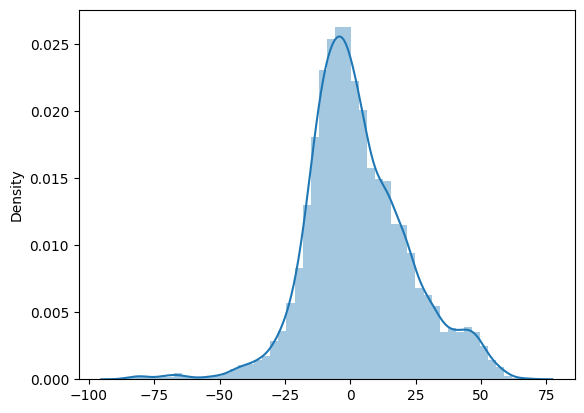

In [104]:
sns.distplot(y_test - y_pred)
plt.show()


In [105]:
(y_test - y_pred).mean()


2.9287529126288008

In [106]:
(y_test - y_pred).std()


19.62381808595668

#### Lasso Regression with hyperparameter tuning

In [107]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV


In [110]:
hyper_params = {'alpha': [1e-7, 1e-4, 1e-2, 1e-1, 1, 5, 10, 15]}

lasso_regressor = GridSearchCV(
    Lasso(), hyper_params, scoring='r2', cv=5, n_jobs=-1)


In [111]:
lasso_regressor.fit(X_train, y_train)
print(lasso_regressor.best_params_)
print(lasso_regressor.best_score_)


{'alpha': 0.1}
0.5879353187826778


In [135]:
y_pred_lasso = lasso_regressor.predict(X_test)

evaluate(y_test, y_pred_lasso)


R2 score = 0.5103255968500358                                         
MAE = 14.74646783869399                                         
MSE = 388.0487362583911                                         
RMSE = 19.698952669073325


C:\Users\SIDDHANT\AppData\Local\Temp\ipykernel_808\3726641957.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test - y_pred_lasso)


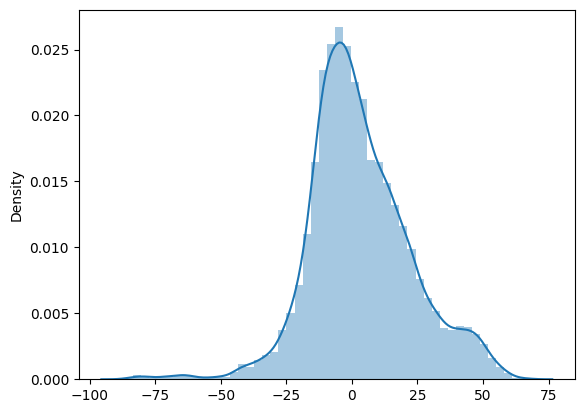

In [113]:
sns.distplot(y_test - y_pred_lasso)
plt.show()


In [114]:
(y_test - y_pred_lasso).mean()


3.190659518347245

In [115]:
(y_test - y_pred_lasso).std()


19.438838136482623

#### Random Forest Regression with hyperparameter tuning

In [116]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV


In [118]:
hyper_params = {'n_estimators': [10, 30, 50, 70, 100, 120],
                'criterion': ['squared_error', 'absolute_error', 'poisson'],
                'max_features': ['sqrt', 'log2', None]}

random_forest_regressor = RandomizedSearchCV(RandomForestRegressor(), hyper_params,
                                             scoring='r2', cv=3, n_jobs=-1)

random_forest_regressor.fit(X_train, y_train)
print(random_forest_regressor.best_params_)
print(random_forest_regressor.best_score_)


{'n_estimators': 100, 'max_features': 'sqrt', 'criterion': 'poisson'}
0.47558238703755146


In [136]:
y_pred_random = random_forest_regressor.predict(X_test)

evaluate(y_test, y_pred_random)


R2 score = 0.35658704596642754                                         
MAE = 16.765162352029375                                         
MSE = 509.8808148820925                                         
RMSE = 22.580540624220948


C:\Users\SIDDHANT\AppData\Local\Temp\ipykernel_808\2391271705.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test - y_pred_random)


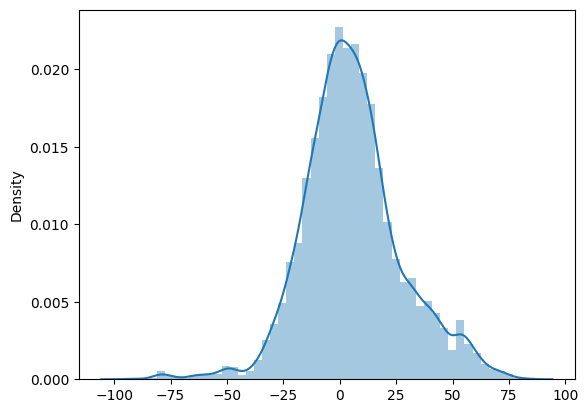

In [120]:
sns.distplot(y_test - y_pred_random)
plt.show()


In [121]:
(y_test - y_pred_random).mean()


5.634411828124595

In [122]:
(y_test - y_pred_random).std()


21.866280393180322

#### Ensemble regression model based on mean 

In [125]:
y_pred_ensemble = [(y_pred[i] + y_pred_lasso[i] +
                    y_pred_random[i])//3 for i in range(len(y_test))]


C:\Users\SIDDHANT\AppData\Local\Temp\ipykernel_808\1472871083.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test - y_pred_ensemble)


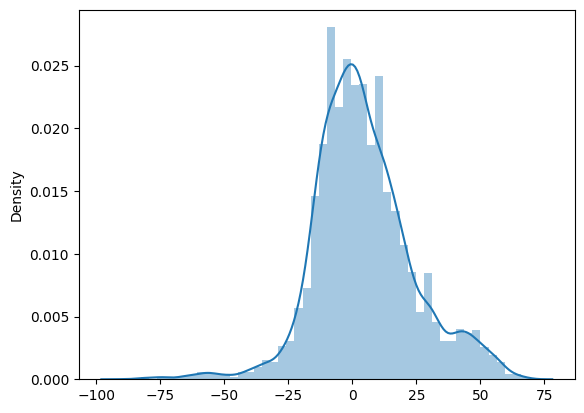

In [126]:
sns.distplot(y_test - y_pred_ensemble)
plt.show()


In [137]:
evaluate(y_test, y_pred_ensemble)


R2 score = 0.4957777318732062                                         
MAE = 14.70794689943626                                         
MSE = 399.5773777050373                                         
RMSE = 19.989431650375586


In [127]:
(y_test - y_pred_ensemble).mean()


4.417166757592289

In [128]:
(y_test - y_pred_ensemble).std()


19.49528187897418

## Dumping the regression model

In [130]:
file = 'first-innings_score_predictor.pkl'
pickle.dump(lasso_regressor, open(file, 'wb'))
#Lasso regressor performs the best based on r2 score


In [117]:
venue_encoder = 'venue_encoder.pkl'
pickle.dump(ohe_venue, open(venue_encoder, 'wb'))

bat_team_encoder = 'bat_team_encoder.pkl'
pickle.dump(ohe_bat_team, open(bat_team_encoder, 'wb'))

bowl_team_encoder = 'bowl_team_encoder.pkl'
pickle.dump(ohe_bowl_team, open(bowl_team_encoder, 'wb'))

scaler_dump = 'scaler.pkl'
pickle.dump(scaler, open(scaler_dump, 'wb'))
